In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import List
from datetime import datetime
from dateutil import parser

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [11]:
def print_unique(df):
    unique_values = {col: df[col].unique() for col in df.columns}
    for column, values in unique_values.items():
        print(f"Unique values in column '{column}': {values}")
        
def drop_cols(df: pd.DataFrame, cols_to_drop: List[str]):
    return df.drop(columns=cols_to_drop)

def convert_year_week_to_date(year_week):
    # Extract year and week from the input
    if isinstance(year_week, int):
        year_week_str = str(year_week)
    else:
        year_week_str = year_week
    year = int(year_week_str[:4])
    week = int(year_week_str[4:])
    # Get the first day of the week (Monday) for the given year and week
    first_date = datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").date()
    return first_date

# Death/Case Rate by State
[From the CDC](https://data.cdc.gov/National-Center-for-Health-Statistics/Provisional-COVID-19-death-counts-rates-and-percen/mpx5-t7tu/about_data)<p>
`state` of the USA<p>
`YYYY-WR` Year and Week of the cumulative period up to that week<p>
`tot_cases` Cumulative Cases (not sure where this came from, check Brookings Atkeson Kissler<p>
`tot_deaths` Cumulative Deaths involving COVID-19 (ICD-10 code U07.1)<p>

In [12]:
df_death_orig = pd.read_csv('CovidDeathsWeek.csv')
print(df_death_orig.columns)
display(df_death_orig.head(2))

Index(['date_updated', 'state', 'start_date', 'end_date', 'tot_cases',
       'new_cases', 'tot_deaths', 'new_deaths', 'new_historic_cases',
       'new_historic_deaths'],
      dtype='object')


,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,01/23/2020,AK,01/16/2020,01/22/2020,0,0,0,0,0,0
1,01/30/2020,AK,01/23/2020,01/29/2020,0,0,0,0,0,0


In [5]:
print_unique(df_death_orig)

Unique values in column 'date_updated': ['01/23/2020' '01/30/2020' '02/06/2020' '02/13/2020' '02/20/2020'
 '02/27/2020' '03/05/2020' '03/12/2020' '03/19/2020' '03/26/2020'
 '04/02/2020' '04/09/2020' '04/16/2020' '04/23/2020' '04/30/2020'
 '05/07/2020' '05/14/2020' '05/21/2020' '05/28/2020' '06/04/2020'
 '06/11/2020' '06/18/2020' '06/25/2020' '07/02/2020' '07/09/2020'
 '07/16/2020' '07/23/2020' '07/30/2020' '08/06/2020' '08/13/2020'
 '08/20/2020' '08/27/2020' '09/03/2020' '09/10/2020' '09/17/2020'
 '09/24/2020' '10/01/2020' '10/08/2020' '10/15/2020' '10/22/2020'
 '10/29/2020' '11/05/2020' '11/12/2020' '11/19/2020' '11/26/2020'
 '12/03/2020' '12/10/2020' '12/17/2020' '12/24/2020' '12/31/2020'
 '01/07/2021' '01/14/2021' '01/21/2021' '01/28/2021' '02/04/2021'
 '02/11/2021' '02/18/2021' '02/25/2021' '03/04/2021' '03/11/2021'
 '03/18/2021' '03/25/2021' '04/01/2021' '04/08/2021' '04/15/2021'
 '04/22/2021' '04/29/2021' '05/06/2021' '05/13/2021' '05/20/2021'
 '05/27/2021' '06/03/2021' '06/10/20

In [6]:
df_death = df_death_orig.copy()
df_death['date'] = pd.to_datetime(df_death['date_updated'], format='mixed')
df_death['year_week'] = df_death['date'].dt.strftime('%Y-W%U')
df_death = df_death.drop(columns=['date', 'date_updated', 'start_date', 'end_date', 'new_cases', 'new_deaths', 'new_historic_cases', 'new_historic_deaths']).dropna()
display(df_death.describe())
display(df_death.head(100))

,tot_cases,tot_deaths
count,1.038000e+04,10380.000000
mean,8.326044e+05,10865.156936
std,1.427126e+06,16343.375401
min,0.000000e+00,0.000000
25%,2.900475e+04,536.000000
50%,3.009370e+05,4215.000000
75%,1.000664e+06,14557.500000
max,1.225182e+07,101886.000000


,state,tot_cases,tot_deaths,year_week
0,AK,0,0,2020-W03
1,AK,0,0,2020-W04
2,AK,0,0,2020-W05
3,AK,0,0,2020-W06
4,AK,0,0,2020-W07
5,AK,0,0,2020-W08
6,AK,0,0,2020-W09
7,AK,0,0,2020-W10
8,AK,11,0,2020-W11
9,AK,63,1,2020-W12


# Seroprevalence by State
[CDC 2020-2021](https://data.cdc.gov/Laboratory-Surveillance/2020-2021-Nationwide-Blood-Donor-Seroprevalence-Su/mtc3-kq6r/about_data) 
[CDC 2022-2023](https://data.cdc.gov/Laboratory-Surveillance/2022-2023-Nationwide-Blood-Donor-Seroprevalence-Su/ar8q-3jhn/about_data)<p>
`n_samples` (Unweighted) Number of blood specimens tested for antibodies for when indicator is overall. For other indicators, number of blood specimens that tested positive for antibodies meeting definition in indicator.<p>
`n_infected` Estimated % (weighted) Seroprevalence rate times n_samples average of N = Normalized infection estimate from commercial COVID testing data and S = Seroprevalence estimate (antibodies detected via serological surveys). Some data missing, just use the other one.<p>
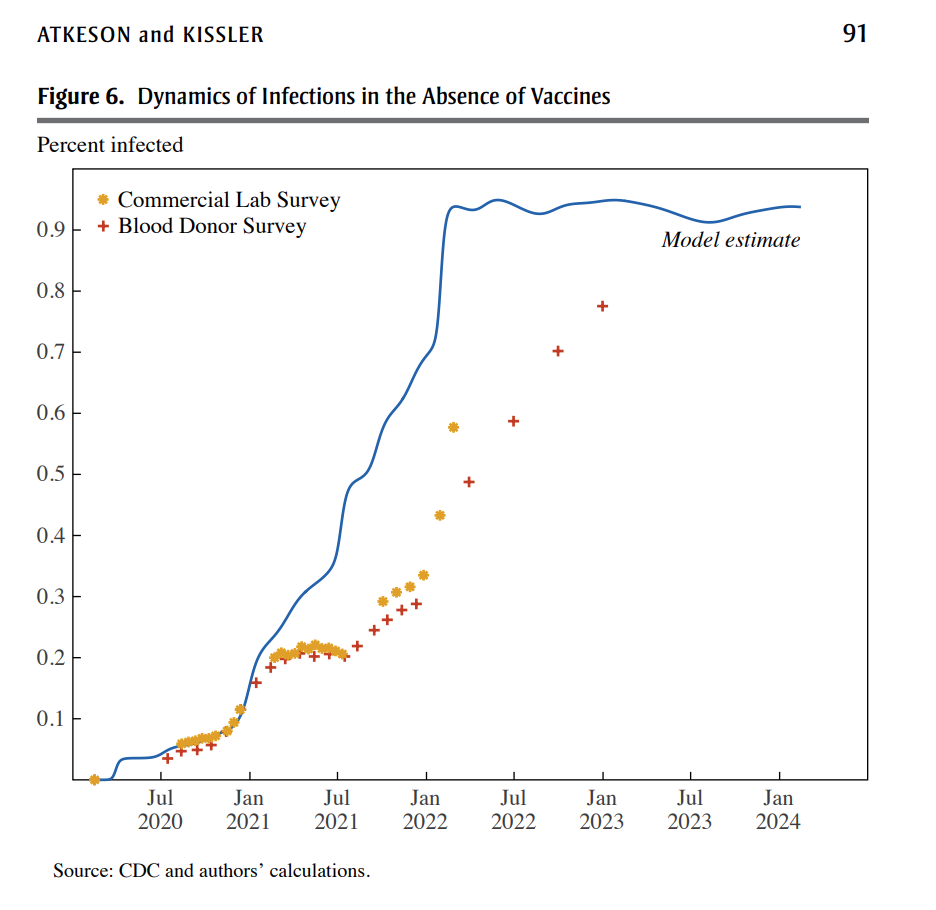
Nationwide COVID-19 seroprevalence survey of blood donors. De-identified blood samples are tested for antibodies to SARS-CoV-2 to better understand the percentage of people in the United States who have antibodies against SARS-CoV-2 (the virus that causes COVID-19) and to track how this percentage changes over time.

In [7]:
# Data was combined into a single set
df_sero_orig = pd.read_csv('SeroDataFull.csv')
print(df_sero_orig.columns)
display(df_sero_orig.head(2))

Index(['state', 'date1', 'date2', 'n', 'rate', 'lwr', 'upr', 'metric',
       'survey'],
      dtype='object')


,state,date1,date2,n,rate,lwr,upr,metric,survey
0,AK,8/6/2020,8/11/2020,242.0,0.3,0.00,1.12,N,Commerical
1,AL,7/29/2020,8/13/2020,938.0,5.8,4.16,7.71,N,Commerical


In [8]:
df_sero = df_sero_orig.copy()
df_sero = df_sero.rename(columns={'n': 'n_samples'})
df_sero['date'] = pd.to_datetime(df_sero['date1'], format='mixed')
df_sero['year_week'] = df_sero['date'].dt.strftime('%Y-W%U')
df_sero['n_infected'] = df_sero['n_samples'] * df_sero['rate']
df_sero = df_sero.drop(columns=['rate', 'date1', 'date2', 'lwr', 'upr']).dropna()
df_sero = df_sero.pivot_table(index=['state', 'year_week'], columns='metric', values=['n_samples', 'n_infected'], aggfunc='first').reset_index()
df_sero.columns = ['state', 'year_week', 'n_samples_N', 'n_samples_S', 'n_infected_N', 'n_infected_S']
df_sero['n_samples'] = df_sero[['n_samples_N', 'n_samples_S']].mean(axis=1, skipna=True)
df_sero['n_infected'] = df_sero[['n_infected_N', 'n_infected_S']].mean(axis=1, skipna=True)
df_sero = drop_cols(df_sero, ['n_samples_N', 'n_samples_S', 'n_infected_N', 'n_infected_S'])
display(df_sero.head(10))

,state,year_week,n_samples,n_infected
0,AK,2020-W31,72.6,242.0
1,AK,2020-W32,915.2,704.0
2,AK,2020-W34,610.0,610.0
3,AK,2020-W36,272.4,681.0
4,AK,2020-W38,894.6,994.0
5,AK,2020-W39,2660.6,1004.0
6,AK,2020-W40,1456.5,971.0
7,AK,2020-W43,8901.9,1413.0
8,AK,2020-W44,3379.8,786.0
9,AK,2020-W45,4036.5,621.0


In [9]:
df_sero.describe()

,n_samples,n_infected
count,2345.000000,2345.000000
mean,54474.314891,1635.513433
std,70955.468237,1150.517587
min,0.000000,1.000000
25%,10290.000000,1008.000000
50%,27943.300000,1320.000000
75%,73425.000000,1817.000000
max,666777.940000,7696.000000


# Vaccination Rates
[CDC](https://data.cdc.gov/Public-Health-Surveillance/Rates-of-COVID-19-Cases-or-Deaths-by-Age-Group-and/d6p8-wqjm/about_data) Kept only `all_ages` `all_producs` (Vaccines)<p>
`boosted_with_outcome` Weekly count of individuals vaccinated with a primary series and booster dose with the corresponding outcome.<p>
`boosted_population` Cumulative weekly count of the population vaccinated with a primary series and booster dose.<p>
`primary_series_only_with_outcome` Weekly count of individuals vaccinated with a primary series only with the corresponding outcome.<p>
`primary_series_only_population` Cumulative weekly count of the population vaccinated with a primary series only.<p>
`unvaccinated_with_outcome` Weekly count of unvaccinated individuals with the corresponding outcome.<p>
`unvaccinated_population` Cumulative weekly estimated count of the unvaccinated population.<p>
`crude_booster_ir` Unadjusted incidence rate of the corresponding outcome among the population vaccinated with a primary series and booster dose (per 100,000 population).<p>
`crude_primary_series_only_ir` Unadjusted incidence rate of the corresponding outcome among the population vaccinated with a primary series only (per 100,000 population).<p>
`crude_unvax_ir` Unadjusted incidence rate of the corresponding outcome among the unvaccinated population (per 100,000 population).<p>
`crude_booster_irr` Unadjusted incidence rate ratio (unvaccinated rate : vaccinated with a primary series and booster dose rate).<p>

In [10]:
df_vax_orig = pd.read_csv('VaccineRates.csv')
print(df_vax_orig.columns)
df_vax = df_vax_orig.copy()
df_vax['date'] = pd.to_datetime(df_vax['mmwr_week'].apply(convert_year_week_to_date))
df_vax['year_week'] = df_vax['date'].dt.strftime('%Y-W%U')
df_vax['age_group'] = df_vax['age_group'].replace('11-May', '5-11', regex=False)
df_vax['age_group'] = df_vax['age_group'].replace('17-Dec', '12-17', regex=False)
df_vax = df_vax[df_vax["vaccine_product"] == "all_types"]
df_vax = df_vax[df_vax["age_group"] == "all_ages"]
df_vax = df_vax.drop(columns=['date', 'month', 'mmwr_week', 'vaccine_product', 'age_group', 'continuity_correction']).dropna()
display(df_vax)

Index(['outcome', 'month', 'mmwr_week', 'age_group', 'vaccine_product',
       'boosted_with_outcome', 'boosted_population',
       'primary_series_only_with_outcome', 'primary_series_only_population',
       'unvaccinated_with_outcome', 'unvaccinated_population',
       'crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
       'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
       'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
       'age_adj_irr', 'continuity_correction'],
      dtype='object')


,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,year_week
6,case,546,1562854,107943,111647895,240670,49474362.80,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464,2021-W38
13,case,624,1898762,102107,112762094,204700,48423938.80,32.863518,90.550819,422.724803,12.863042,4.668371,37.710445,91.303257,426.371625,11.306460,4.669840,2021-W39
20,case,746,2315541,96205,113676350,180689,47500945.80,32.217093,84.630620,380.390321,11.807096,4.494713,39.582996,85.177244,385.323914,9.734582,4.523789,2021-W40
27,case,896,3983836,86980,113130056,155652,46689549.80,22.490886,76.884962,333.376528,14.822739,4.336043,27.623276,77.145609,340.206551,12.315938,4.409928,2021-W41
34,case,1196,5945158,82286,112184292,141203,45959133.50,20.117211,73.348950,307.235993,15.272295,4.188690,22.607625,73.488728,313.852581,13.882599,4.270758,2021-W42
41,case,1667,7676755,84909,111320676,140703,45117494.80,21.714904,76.274240,311.859071,14.361522,4.088655,27.499929,76.744013,318.415126,11.578762,4.149055,2021-W43
48,case,2270,9434275,92665,110334469,142186,44287334.80,24.061202,83.985540,321.053413,13.343199,3.822722,32.692426,85.824366,326.894396,9.999087,3.808876,2021-W44
55,case,3078,12974195,101144,107546726,154940,43530835.15,23.724015,94.046564,355.931604,15.003009,3.784632,31.561815,95.483843,363.133533,11.505470,3.803089,2021-W45
62,case,4369,16940059,109049,104291452,167035,42731285.00,25.790937,104.561781,390.896272,15.156342,3.738424,34.537477,105.475385,402.342009,11.649433,3.814558,2021-W46
70,case,5031,20667670,98627,101186929,149949,41973691.00,24.342367,97.470099,357.245209,14.675862,3.665177,31.865419,98.005215,371.375696,11.654505,3.789346,2021-W47


In [11]:
df_vax.describe()

,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr
count,103.000000,1.030000e+02,1.030000e+02,1.030000e+02,1.030000e+02,1.030000e+02,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,58173.213592,5.100451e+07,9.789210e+04,8.327346e+07,1.283263e+05,4.517251e+07,97.535025,112.890200,281.660247,4.971444,3.592550,106.155589,113.774793,301.724373,11.247584,5.645609
std,92721.365345,2.431710e+07,2.398659e+05,1.299632e+07,2.656286e+05,5.061538e+06,167.923720,268.510086,587.406033,4.872541,1.727686,193.258471,272.201650,598.009670,13.412223,3.726126
min,20.000000,1.496531e+06,1.000000e+02,7.012206e+07,1.890000e+02,3.727718e+07,0.185571,0.138696,0.472262,1.057514,2.040894,0.097628,0.138120,0.851668,1.053674,2.065930
25%,393.500000,3.371025e+07,4.615000e+02,7.405285e+07,8.080000e+02,4.108697e+07,0.745090,0.623421,1.780811,1.419610,2.396832,0.352642,0.601156,3.471183,2.252207,3.003710
50%,1267.000000,6.314071e+07,2.022200e+04,7.691817e+07,2.939700e+04,4.341401e+07,21.714904,26.644291,69.786789,2.369104,2.776659,27.499929,26.819468,77.627296,6.106049,4.523789
75%,99125.000000,6.878348e+07,1.016255e+05,9.013156e+07,1.551935e+05,5.107008e+07,146.058983,107.237121,336.898621,6.046118,4.126668,148.531767,107.182285,373.321740,13.799995,6.672015
max,442313.000000,7.503560e+07,1.533800e+06,1.136764e+08,1.613527e+06,5.407783e+07,942.501753,1686.514587,3492.642506,18.293145,8.586756,1146.200229,1712.546562,3538.001796,66.008977,16.190444


## Merge DFs

In [12]:
display(df_sero.head(2))
display(df_death.head(2))
display(df_vax.head(2))

,state,year_week,n_samples,n_infected
0,AK,2020-W31,72.6,242.0
1,AK,2020-W32,915.2,704.0


,state,tot_cases,tot_deaths,year_week
0,AK,0,0,2020-W03
1,AK,0,0,2020-W04


,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,year_week
6,case,546,1562854,107943,111647895,240670,49474362.8,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464,2021-W38
13,case,624,1898762,102107,112762094,204700,48423938.8,32.863518,90.550819,422.724803,12.863042,4.668371,37.710445,91.303257,426.371625,11.306460,4.669840,2021-W39


In [13]:
print('df_death', df_death.columns)
print('df_sero', df_sero.columns)
print('df_vax', df_vax.columns)

df_death Index(['state', 'tot_cases', 'tot_deaths', 'year_week'], dtype='object')
df_sero Index(['state', 'year_week', 'n_samples', 'n_infected'], dtype='object')
df_vax Index(['outcome', 'boosted_with_outcome', 'boosted_population',
       'primary_series_only_with_outcome', 'primary_series_only_population',
       'unvaccinated_with_outcome', 'unvaccinated_population',
       'crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
       'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
       'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
       'age_adj_irr', 'year_week'],
      dtype='object')


In [14]:
df_death_sero = pd.merge(df_death, df_sero, on=["state", "year_week"], how="outer")
display(df_death_sero.head(50))

,state,tot_cases,tot_deaths,year_week,n_samples,n_infected
0,AK,0.0,0.0,2020-W03,NaN,NaN
1,AK,0.0,0.0,2020-W04,NaN,NaN
2,AK,0.0,0.0,2020-W05,NaN,NaN
3,AK,0.0,0.0,2020-W06,NaN,NaN
4,AK,0.0,0.0,2020-W07,NaN,NaN
5,AK,0.0,0.0,2020-W08,NaN,NaN
6,AK,0.0,0.0,2020-W09,NaN,NaN
7,AK,0.0,0.0,2020-W10,NaN,NaN
8,AK,11.0,0.0,2020-W11,NaN,NaN
9,AK,63.0,1.0,2020-W12,NaN,NaN


In [15]:
df_death_sero.to_csv('death_sero.csv', index=False)
df_vax.to_csv('vaccine.csv', index=False)

# Analysis

In [22]:
filtered_df = df_death_sero[df_death_sero["state"].isin(["CA", "FL", "TX"])]
filtered_df.head()
filtered_df['year'] = filtered_df['year_week'].str.split('-').str[0].astype(int)
averages = filtered_df.groupby(['state', 'year'])[['tot_cases', 'tot_deaths']].mean()
print(averages)

               tot_cases     tot_deaths
state year                             
CA    2020  5.120195e+05    8732.120000
      2021  4.129310e+06   60943.865385
      2022  1.003382e+07   90568.807692
      2023  1.210051e+07  100381.052632
FL    2020  3.759536e+05    7641.900000
      2021  2.640017e+06   41945.288462
      2022  6.391604e+06   75745.442308
      2023  7.478803e+06   86270.315789
TX    2020  4.590364e+05    8635.800000
      2021  3.252734e+06   55156.865385
      2022  7.220451e+06   87727.750000
      2023  8.400530e+06   92985.052632


C:\Users\steve\AppData\Local\Temp\ipykernel_42580\2425031935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = filtered_df['year_week'].str.split('-').str[0].astype(int)
